In [139]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Importing functions from the modules in the qseg package
from qseg.graph_utils import image_to_grid_graph, draw, draw_graph_cut_edges
from qseg.utils import decode_binary_string

# Additional necessary imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import cirq
import sympy
from scipy.optimize import minimize

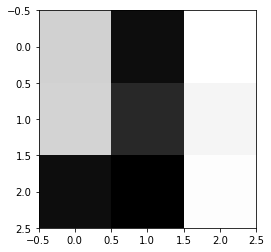

In [140]:
height, width = 3, 3

image = np.array([
       [0.82,  0.1, 0.99],
       [0.83,  0.2, 0.95],
       [0.1,  0.05, 0.98]
       ])
plt.imshow(image, cmap=plt.cm.gray)



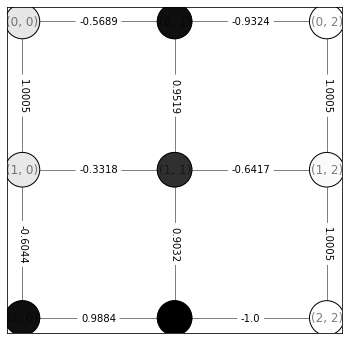

In [141]:
# Convert image to graph
normalized_nx_elist = image_to_grid_graph(image)  # Gaussian similarity metric as the edge weight metric
G = nx.grid_2d_graph(image.shape[0], image.shape[1])
G.add_weighted_edges_from(normalized_nx_elist)
draw(G, image)

In [151]:
def cirq_qaoa_solver(G, n_shots=10000, p=1):
    """
    Resolver MaxCut en un grafo usando QAOA con Cirq.

    Parámetros:
    G (networkx.Graph): Grafo de la imagen.
    n_shots (int): Número de repeticiones del circuito.
    p (int): Número de capas QAOA.

    Retorna:
    - np.array: Mejor máscara de segmentación encontrada.
    - dict: Información de tiempos de ejecución.
    """
    start_time = time.time()

    # Definir qubits para cada píxel
    qubits = [cirq.GridQubit(i, j) for i in range(height) for j in range(width)]

    # Parámetros simbólicos para QAOA
    beta = sympy.Symbol('beta')
    gamma = sympy.Symbol('gamma')

    # Construcción del circuito QAOA
    circuit = cirq.Circuit()

    # 1️⃣ Aplicar Hadamard a todos los qubits
    circuit.append(cirq.H.on_each(qubits))

    # 2️⃣ Aplicar operador de fase basado en las aristas (Cost Hamiltonian)
    for u, v in G.edges():
        qubit_u = cirq.GridQubit(*u)
        qubit_v = cirq.GridQubit(*v)
        circuit.append(cirq.CZ(qubit_u, qubit_v)**gamma)

    # 3️⃣ Aplicar operador de mezcla (Mixing Hamiltonian)
    for qubit in qubits:
        circuit.append(cirq.rx(2 * beta).on(qubit))

    # Medición final
    circuit.append(cirq.measure(*qubits, key='result'))

    # ⏳ Tiempo de formulación del problema
    problem_formulation_time = time.time() - start_time

    # Función de costo para optimizar parámetros de QAOA
    def cost_function(params):
        beta_val, gamma_val = params
        resolved_circuit = cirq.resolve_parameters(circuit, {'beta': beta_val, 'gamma': gamma_val})
        simulator = cirq.Simulator()
        result = simulator.run(resolved_circuit, repetitions=n_shots)
        samples = result.measurements['result']
        
        cut_value = 0
        for sample in samples:
            solution = {node: sample[i] for i, node in enumerate(G.nodes())}
            cut_value += sum(1 for u, v in G.edges() if solution[u] != solution[v])

        return -cut_value  # Maximizar el corte equivale a minimizar su negativo

    # 🔍 Optimización de parámetros beta y gamma
    start_time = time.time()
    initial_params = [np.pi / 4, np.pi / 4]
    opt_result = minimize(cost_function, initial_params, method='COBYLA')
    beta_opt, gamma_opt = opt_result.x
    optimization_time = time.time() - start_time

    # 🔄 Ejecutar circuito con parámetros óptimos
    start_time = time.time()
    final_circuit = cirq.resolve_parameters(circuit, {'beta': beta_opt, 'gamma': gamma_opt})
    simulator = cirq.Simulator()
    result = simulator.run(final_circuit, repetitions=n_shots)
    sample_fetch_time = time.time() - start_time

    # 🏆 Seleccionar mejor solución
    samples = result.measurements['result']
    best_solution = None
    max_cut_value = float('-inf')

    for sample in samples:
        solution = {node: sample[i] for i, node in enumerate(G.nodes())}
        cut_value = sum(1 for u, v in G.edges() if solution[u] != solution[v])
        if cut_value > max_cut_value:
            max_cut_value = cut_value
            best_solution = solution

    # Convertir mejor solución a una máscara binaria
    solution_binary_string = ''.join(map(str, best_solution.values()))
    segmentation_mask = decode_binary_string(solution_binary_string, height, width)

    # 📊 Información de tiempos
    info_dict = {
        'problem_formulation_time': problem_formulation_time,
        'optimization_time': optimization_time,
        'sample_fetch_time': sample_fetch_time
    }

    return segmentation_mask, info_dict


Tiempos de ejecución: {'problem_formulation_time': 0.0, 'optimization_time': 10.64916706085205, 'sample_fetch_time': 0.10983490943908691}


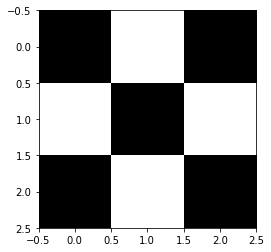

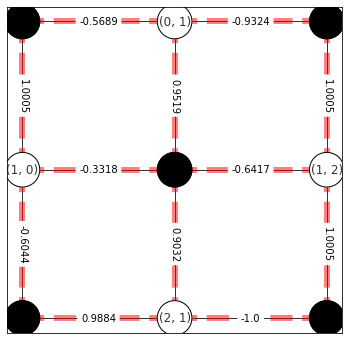

In [153]:
# Run quantum solver
import time
start_time = time.time()
segmentation_mask, info = cirq_qaoa_solver(G)
total_time = time.time() - start_time

# Visualizar máscara segmentada
plt.imshow(segmentation_mask, cmap=plt.cm.gray)

# Extraer y dibujar bordes del corte óptimo
cut_edges = [(u, v) for (u, v, d) in G.edges(data=True) if segmentation_mask[u] != segmentation_mask[v]]
draw_graph_cut_edges(G, segmentation_mask, cut_edges)

# Mostrar tiempos de ejecución
print("Tiempos de ejecución:", info)

In [ ]:
#OTRO exemplo 

In [155]:
from scipy.optimize import minimize

opt_result = minimize(cost_function, initial_params, args=(G, simulator), method='Nelder-Mead')
beta_opt, gamma_opt = opt_result.x


def qaoa_maxcut_circuit(G, beta, gamma, p=3):
    qubits = [cirq.GridQubit(i, j) for i in range(height) for j in range(width)]
    circuit = cirq.Circuit()
    
    # Estado inicial
    circuit.append(cirq.H.on_each(qubits))
    
    for _ in range(p):
        # Operador de costo
        for u, v in G.edges():
            qubit_u = cirq.GridQubit(*u)
            qubit_v = cirq.GridQubit(*v)
            circuit.append(cirq.CZ(qubit_u, qubit_v))
            circuit.append(cirq.Z(qubit_u) ** gamma)
            circuit.append(cirq.Z(qubit_v) ** gamma)
        
        # Operador de mezcla
        for qubit in qubits:
            circuit.append(cirq.rx(2 * beta).on(qubit))
    
    circuit.append(cirq.measure(*qubits, key='result'))
    return circuit

def cost_function(params, G, simulator, n_shots=5000):
    beta, gamma = params
    circuit = qaoa_maxcut_circuit(G, beta, gamma)
    result = simulator.run(circuit, repetitions=n_shots)
    samples = result.measurements['result']
    
    # Contar ocurrencias de cada resultado
    unique_samples, counts = np.unique(samples, axis=0, return_counts=True)
    total_counts = np.sum(counts)
    
    # Calcular la esperanza del valor del corte
    cut_expectation = 0
    for sample, count in zip(unique_samples, counts):
        solution = {qubit: bit for qubit, bit in zip(G.nodes(), sample)}
        cut_value = sum(1 for u, v in G.edges() if solution[u] != solution[v])
        cut_expectation += (count / total_counts) * cut_value  # Probabilidad * Valor del corte
    
    return -cut_expectation  # Negativo porque optimizamos minimizando


# Optimize beta and gamma
simulator = cirq.Simulator()

initial_params = [np.pi / 4, np.pi / 4]  # Initial guesses for beta and gamma
opt_result = minimize(cost_function, initial_params, args=(G, simulator), method='COBYLA')
beta_opt, gamma_opt = opt_result.x

# Run optimized quantum solver
circuit = qaoa_maxcut_circuit(G, beta_opt, gamma_opt)
result = simulator.run(circuit, repetitions=50000)
samples = result.measurements['result']

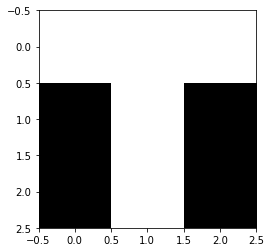

In [156]:
# Convert results to binary segmentation mask
solution_binary_string = ''.join(map(str, samples[0]))
segmentation_mask = decode_binary_string(solution_binary_string, height, width)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)

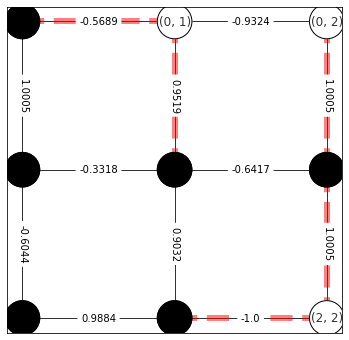

In [130]:
# Extract cut edges
cut_edges = [(u, v) for (u, v, d) in G.edges(data=True) if segmentation_mask[u] != segmentation_mask[v]]
cut_edges
draw_graph_cut_edges(G, segmentation_mask, cut_edges)